# 役割
オフライン検証を行うnotebook。事前に`v3_2_0/data/02_features/features.csv`を作成しておく必要がある。
- 学習データ：2018年1月〜2022年9月
- 検証データ（Early stopping・Calibration補正）：2022年10月〜2022年12月
    - Early stoppingについては[#14の記事](https://note.com/dijzpeb/n/n67ef63cf345f)、Calibration補正については[#22の記事](https://note.com/dijzpeb/n/nef0d54028813)で解説
- テストデータ：2023年1月〜2023年12月

# インポート

In [1]:
from training import Dataset, Trainer
from evaluationing import plot_calibration, Evaluator
from pathlib import Path
%load_ext autoreload

In [2]:
# モジュールを更新した場合、以下を実行することで更新を反映させる
%autoreload

# 学習

In [2]:
# データセット作成
dataset = Dataset(
    train_start_date="2012-01-01",
    train_end_date="2021-09-30",
    valid_start_date="2021-10-01",
    valid_end_date="2021-12-31",
    test_start_date="2022-01-01",
    test_end_date="2024-12-31",
    features_filename="features12-24.csv",
    target_strategy=0,  # 1着と0.0秒差も1着として扱う
)

In [17]:
# 各特徴量の欠損値を確認
dataset.test_df['rank_mean_1000races_relative'].isnull().sum()

np.int64(4832)

In [3]:
# 学習実行
trainer = Trainer(config_filepath="config.yaml")
evaluation_df = trainer.run(
    dataset=dataset,
    importance_filename="importance",
    model_filename="model.pkl",
    calibration_model_filename="calibration_model.pkl",
    evaluation_filename="evaluation.csv",
)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.215725
[200]	valid_0's binary_logloss: 0.207814
[300]	valid_0's binary_logloss: 0.20578
[400]	valid_0's binary_logloss: 0.205217
[500]	valid_0's binary_logloss: 0.20497
[600]	valid_0's binary_logloss: 0.204864
[700]	valid_0's binary_logloss: 0.204822
[800]	valid_0's binary_logloss: 0.204725
Early stopping, best iteration is:
[781]	valid_0's binary_logloss: 0.204711
-------------------- result --------------------
test_df's binary_logloss: 0.20436055763898953


In [ ]:
# オッズと人気を特徴量から省いた場合
trainer = Trainer(config_filepath="config_pop_removed.yaml")
evaluation_df = trainer.run(
    dataset=dataset,
    importance_filename="importance_pop_removed",
    model_filename="model_pop_removed.pkl",
    calibration_model_filename="calibration_model_pop_removed.pkl",
    evaluation_filename="evaluation_pop_removed.csv",
)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.232985
[200]	valid_0's binary_logloss: 0.226106
[300]	valid_0's binary_logloss: 0.223261
[400]	valid_0's binary_logloss: 0.221872
[500]	valid_0's binary_logloss: 0.221234
[600]	valid_0's binary_logloss: 0.220805
[700]	valid_0's binary_logloss: 0.220535
[800]	valid_0's binary_logloss: 0.220294
[900]	valid_0's binary_logloss: 0.220216
[1000]	valid_0's binary_logloss: 0.22007
[1100]	valid_0's binary_logloss: 0.220017
Early stopping, best iteration is:
[1089]	valid_0's binary_logloss: 0.219993
-------------------- result --------------------
test_df's binary_logloss: 0.22320513458451896


# 精度評価

In [4]:
evaluator = Evaluator(evaluation_filename="evaluation.csv")

## キャリブレーション

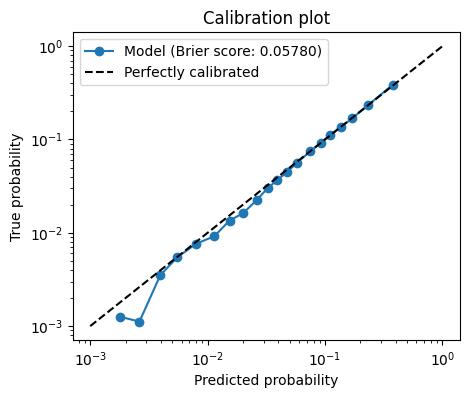

In [5]:
# 補正前
evaluator.plot_calibration()

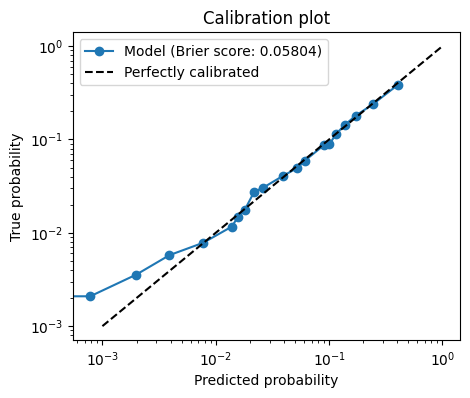

In [6]:
# 補正後
evaluator.plot_calibration(pred_col="pred_calibrated")

best result:
{'expect_return': 1.587878787878788,
 'n_hits': 10.0,
 'return_rate': 1.1555555555555554,
 'sharp_ratio': 0.36578103248705557,
 'std': 0.4252696059658597,
 'total_bet': 180.0,
 'total_payoff': 208.0}


,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
65,1.587879,180,208.0,1.155556,0.425270,10,0.365781
64,1.575758,189,208.0,1.100529,0.405366,10,0.247996
63,1.563636,201,208.0,1.034826,0.381524,10,0.091281
61,1.539394,230,235.3,1.023043,0.343581,12,0.067069
62,1.551515,213,208.0,0.976526,0.360358,10,-0.065141


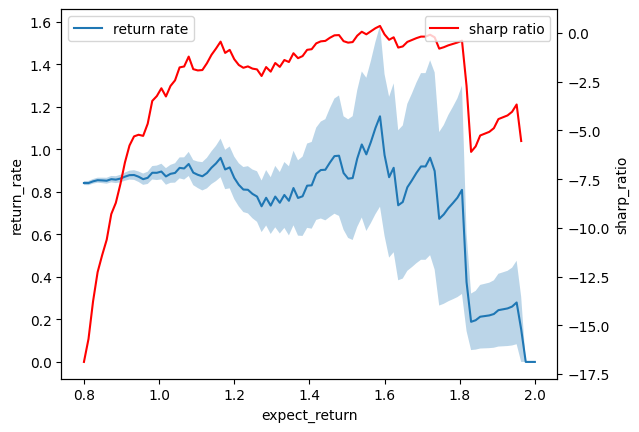

In [10]:
result_df = evaluator.bet_by_expect_return(
    min_exp=0.8, max_exp=2, min_pred=0.03, pred_col="pred"
)
result_df.sort_values("sharp_ratio", ascending=False).head()

best result:
{'expect_return': 1.4282828282828284,
 'n_hits': 70.0,
 'return_rate': 1.1759943181818182,
 'sharp_ratio': 0.9301114642899901,
 'std': 0.18921852373485712,
 'total_bet': 704.0,
 'total_payoff': 827.9000000000001}


,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
53,1.428283,704,827.9,1.175994,0.189219,70,0.930111
49,1.395960,888,1015.4,1.143468,0.160788,107,0.892286
48,1.387879,924,1052.6,1.139177,0.157144,109,0.885669
52,1.420202,742,854.1,1.151078,0.181221,72,0.833668
51,1.412121,770,877.9,1.140130,0.177250,73,0.790580
50,1.404040,821,925.0,1.126675,0.169833,78,0.745880
60,1.484848,515,594.9,1.155146,0.215487,58,0.719975
47,1.379798,959,1052.6,1.097602,0.151563,109,0.643970
63,1.509091,412,473.3,1.148786,0.251645,25,0.591255
58,1.468687,563,630.1,1.119183,0.202630,60,0.588181


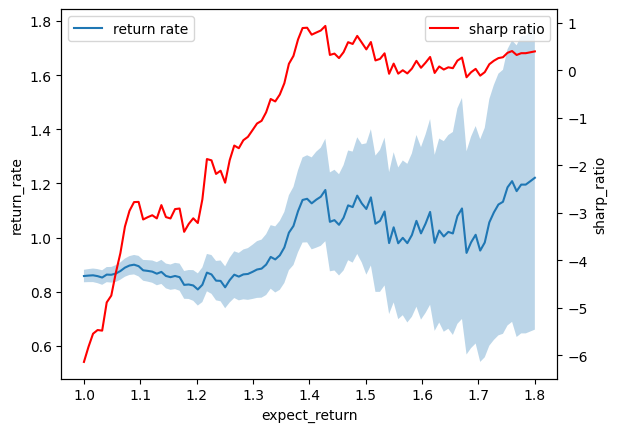

In [9]:
result_df = evaluator.bet_by_expect_return(
    min_exp=1.0, max_exp=1.8,n_samples=100, min_pred=0.03, pred_col="pred_calibrated"
)
result_df.sort_values("sharp_ratio", ascending=False).head(20)

## オッズを特徴量から省いたモデル

In [5]:
evaluator_real_removed = Evaluator(evaluation_filename="evaluation_real.csv")

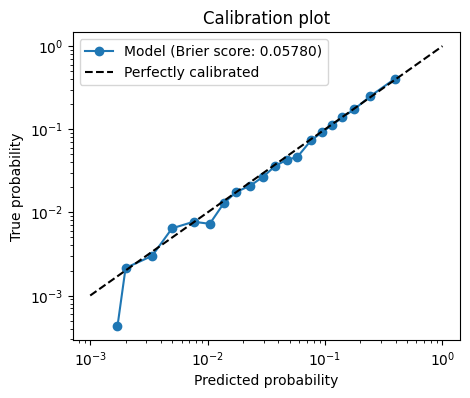

In [6]:
evaluator_real_removed.plot_calibration()

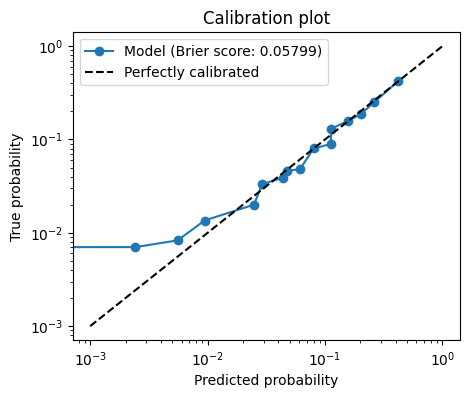

In [7]:
evaluator_real_removed.plot_calibration(pred_col="pred_calibrated")

best result:
{'expect_return': 1.4444444444444444,
 'n_hits': 7.0,
 'return_rate': 1.81864406779661,
 'sharp_ratio': 1.0827103565702705,
 'std': 0.7561062502346888,
 'total_bet': 177.0,
 'total_payoff': 321.9}


,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
44,1.444444,177,321.9,1.818644,0.756106,7,1.082710
43,1.434343,193,321.9,1.667876,0.694176,7,0.962113
37,1.373737,321,442.9,1.379751,0.484110,11,0.784430
42,1.424242,218,321.9,1.476606,0.615405,7,0.774458
32,1.323232,437,557.8,1.276430,0.395413,14,0.699092


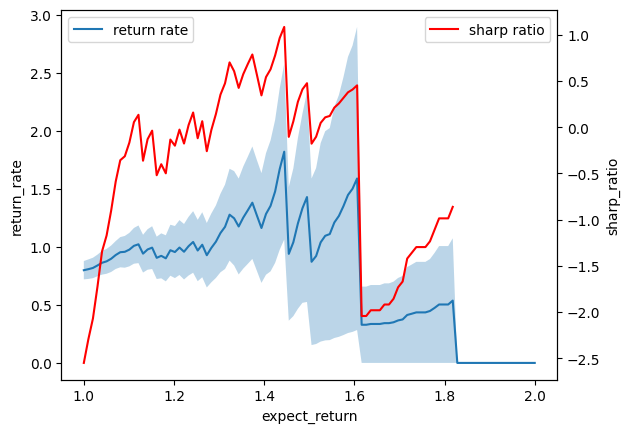

In [10]:
result_df = evaluator_real_removed.bet_by_expect_return(
    min_exp=1.0, max_exp=2, min_pred=0.01, pred_col="pred_calibrated",table_save_filename="table_real_removed.csv"
)
result_df.sort_values("sharp_ratio", ascending=False).head()

best result:
{'expect_return': 1.878787878787879,
 'n_hits': 1.0,
 'return_rate': 0.7666666666666667,
 'sharp_ratio': -0.30434782608695643,
 'std': 0.7666666666666667,
 'total_bet': 21.0,
 'total_payoff': 16.1}


,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
87,1.878788,21,16.1,0.766667,0.766667,1,-0.304348
84,1.848485,22,16.1,0.731818,0.731818,1,-0.366460
83,1.838384,22,16.1,0.731818,0.731818,1,-0.366460
85,1.858586,22,16.1,0.731818,0.731818,1,-0.366460
86,1.868687,22,16.1,0.731818,0.731818,1,-0.366460


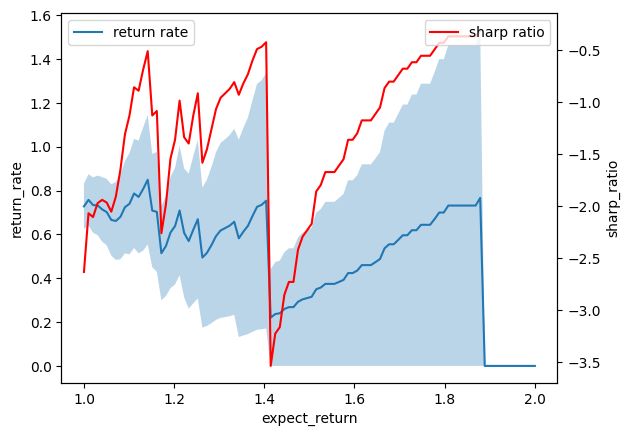

In [ ]:
result_df = evaluator_real_removed.bet_by_expect_return(
    min_exp=1.0, max_exp=2, min_pred=0.01, pred_col="pred",table_save_filename="table_real_removed.csv"
)
result_df.sort_values("sharp_ratio", ascending=False).head( )


In [56]:
# 行番号列のコラム名として"n"をインサートする
result_df = result_df.reset_index()
# result_df = result_df.rename(columns={"index": "n"})
result_df



,level_0,index,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
0,0,0,17564,12881.6,0.733409,0.038427,1119,-6.937588
1,1,1,16518,12022.2,0.727824,0.040313,1009,-6.751523
2,2,2,15481,11282.2,0.728777,0.042475,902,-6.385461
3,3,3,14701,10537.9,0.716815,0.043820,837,-6.462472
4,4,4,13848,9936.4,0.717533,0.045987,756,-6.142326
...,...,...,...,...,...,...,...,...
95,95,95,509,207.2,0.407073,0.407073,1,-1.456564
96,96,96,491,207.2,0.421996,0.421996,1,-1.369691
97,97,97,469,207.2,0.441791,0.441791,1,-1.263514
98,98,98,460,207.2,0.450435,0.450435,1,-1.220077


## 人気も特徴量から外す

In [12]:
evaluator_pop_removed = Evaluator(evaluation_filename="evaluation_pop_removed.csv")

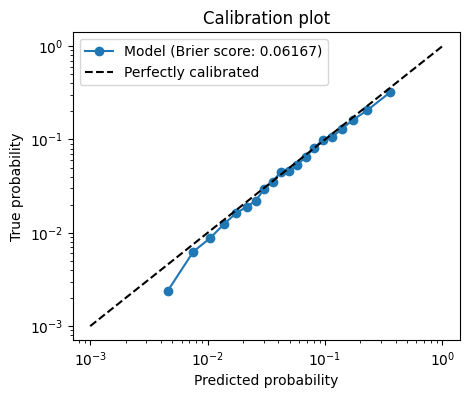

In [13]:
evaluator_pop_removed.plot_calibration()

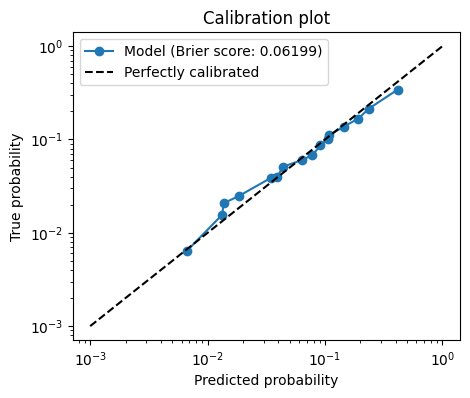

In [14]:
evaluator_pop_removed.plot_calibration(pred_col="pred_calibrated")

best result:
{'expect_return': 12.757575757575758,
 'n_hits': 3.0,
 'return_rate': 0.9966269841269841,
 'sharp_ratio': -0.00540689921678567,
 'std': 0.6238355363725596,
 'total_bet': 504.0,
 'total_payoff': 502.3}


,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
97,12.757576,504,502.3,0.996627,0.623836,3,-0.005407
96,12.636364,516,502.3,0.973450,0.609351,3,-0.043572
95,12.515152,536,502.3,0.937127,0.586647,3,-0.107174
94,12.393939,558,502.3,0.900179,0.563553,3,-0.177127
93,12.272727,580,502.3,0.866034,0.542206,3,-0.247075


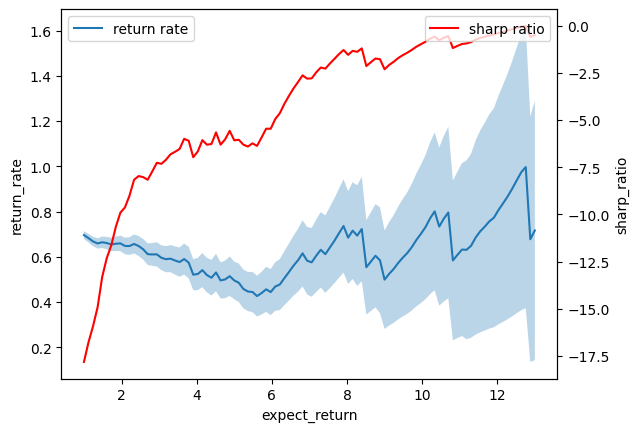

In [15]:
result_df = evaluator_pop_removed.bet_by_expect_return(
    min_exp=1.0, max_exp=13, min_pred=0.01, pred_col="pred",table_save_filename="evaluation_pop_removed.csv"
)
result_df.sort_values("sharp_ratio", ascending=False).head()

best result:
{'expect_return': 10.898989898989898,
 'n_hits': 7.0,
 'return_rate': 1.2464233576642334,
 'sharp_ratio': 0.4545307940497696,
 'std': 0.5421488728379773,
 'total_bet': 685.0,
 'total_payoff': 853.8}


,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
70,10.898990,685,853.8,1.246423,0.542149,7,0.454531
69,10.757576,710,853.8,1.202535,0.523117,7,0.387170
68,10.616162,742,853.8,1.150674,0.500620,7,0.300974
67,10.474747,777,853.8,1.098842,0.478130,7,0.206725
66,10.333333,808,853.8,1.056683,0.459842,7,0.123267


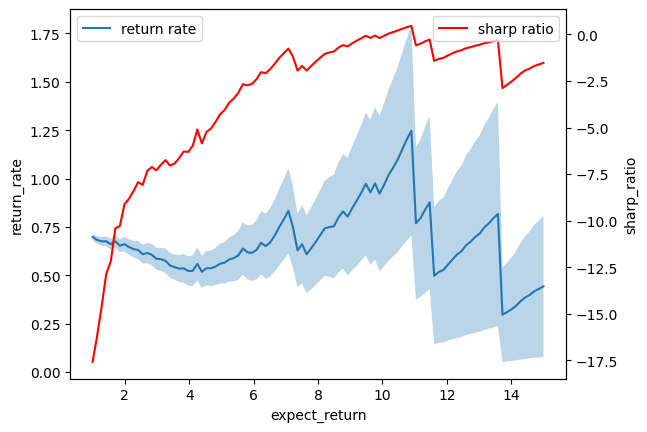

In [16]:
result_df = evaluator_pop_removed.bet_by_expect_return(
    min_exp=1.0, max_exp=15, min_pred=0.01, pred_col="pred_calibrated",table_save_filename="evaluation_pop_removed.csv"
)
result_df.sort_values("return_rate", ascending=False).head()

## 数年分のデータで評価

In [10]:
evaluator_slide = Evaluator(evaluation_filename="evaluation_slide_10.csv")

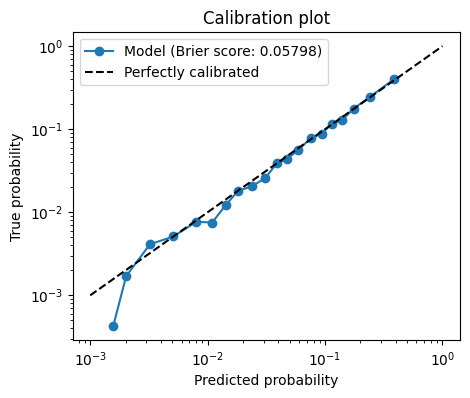

In [11]:
evaluator_slide.plot_calibration()

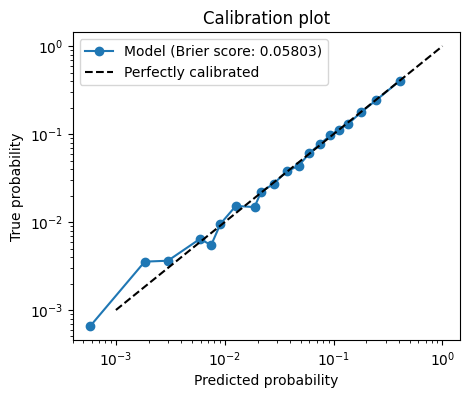

In [12]:
evaluator_slide.plot_calibration(pred_col="pred_calibrated")

best result:
{'expect_return': 1.5636363636363637,
 'n_hits': 9.0,
 'return_rate': 1.3746835443037975,
 'sharp_ratio': 0.6590771315644627,
 'std': 0.5684972613363245,
 'total_bet': 158.0,
 'total_payoff': 217.2}


,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
93,1.563636,158,217.2,1.374684,0.568497,9,0.659077
92,1.557576,160,217.2,1.357500,0.561505,9,0.636682
83,1.503030,198,253.1,1.278283,0.470670,11,0.591248
91,1.551515,165,217.2,1.316364,0.544754,9,0.580746
82,1.496970,199,253.1,1.271859,0.468346,11,0.580467
74,1.448485,249,311.0,1.248996,0.431791,13,0.576658
72,1.436364,265,325.2,1.227170,0.409029,14,0.555388
90,1.545455,168,217.2,1.292857,0.535125,9,0.547268
95,1.575758,150,194.7,1.298000,0.581502,8,0.512466
73,1.442424,256,311.0,1.214844,0.420168,13,0.511328


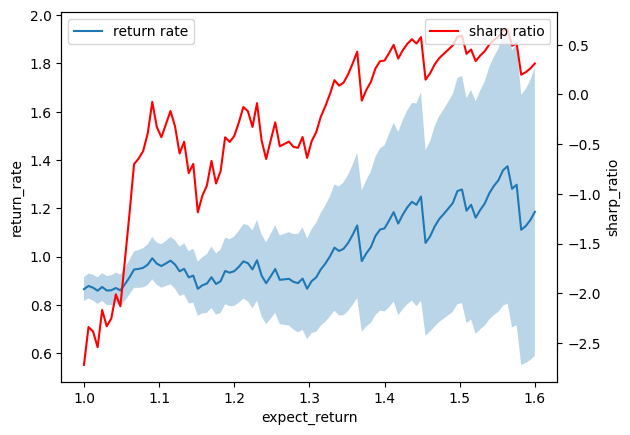

In [20]:
result_df = evaluator_slide.bet_by_expect_return(
    min_exp=1.0, max_exp=1.6, min_pred=0.02, pred_col="pred",table_save_filename="evaluation_slide.csv"
)
result_df.sort_values("sharp_ratio", ascending=False).head(20)

best result:
{'expect_return': 1.3333333333333335,
 'n_hits': 31.0,
 'return_rate': 1.1509090909090909,
 'sharp_ratio': 0.6061228753741343,
 'std': 0.24897441928081168,
 'total_bet': 385.0,
 'total_payoff': 443.1}


,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
66,1.333333,385,443.1,1.150909,0.248974,31,0.606123
64,1.323232,407,462.9,1.137346,0.240266,32,0.571644
65,1.328283,394,443.1,1.124619,0.243430,31,0.511931
62,1.313131,429,480.6,1.120280,0.230973,34,0.520753
60,1.303030,454,505.1,1.112555,0.219670,38,0.512382
61,1.308081,433,480.6,1.109931,0.228884,34,0.480289
63,1.318182,422,462.9,1.096919,0.231961,32,0.417826
56,1.282828,523,573.4,1.096367,0.199991,44,0.481857
67,1.338384,378,412.0,1.089947,0.240757,30,0.373600
59,1.297980,466,506.4,1.086695,0.214164,39,0.404807


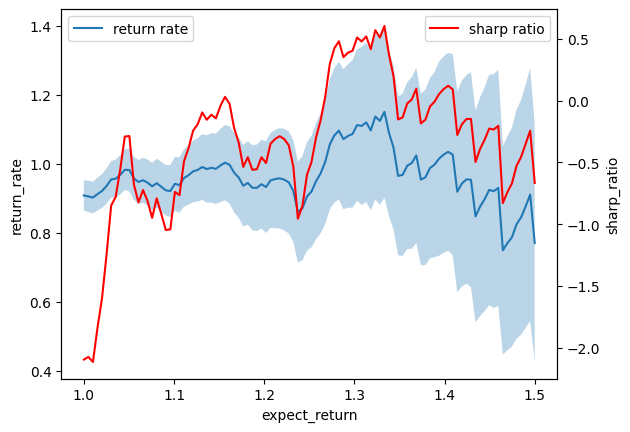

In [16]:
result_df = evaluator_slide.bet_by_expect_return(
    min_exp=1.0, max_exp=1.5, min_pred=0.03, pred_col="pred_calibrated",table_save_filename="evaluation_slide.csv"
)
result_df.sort_values("return_rate", ascending=False).head(20)

# 精度がでた評価データ

best result:
{'expect_return': 1.5474747474747474,
 'n_hits': 3.0,
 'return_rate': 1.126923076923077,
 'sharp_ratio': 0.19483116600444078,
 'std': 0.6514516107766042,
 'total_bet': 52.0,
 'total_payoff': 58.6}


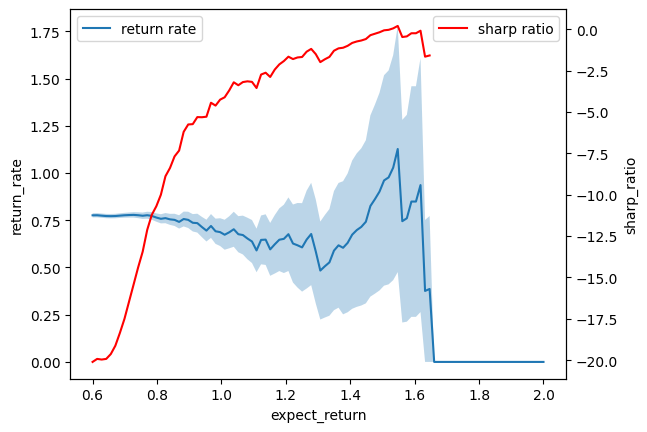

In [ ]:
result_df = evaluator.bet_by_expect_return(
    min_exp=0.6, max_exp=2.0, min_pred=0.05, pred_col="pred"
)

In [ ]:
result_df.sort_values("sharp_ratio", ascending=False).head()

,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
67,1.547475,52,58.6,1.126923,0.651452,3,0.194831
66,1.533333,57,58.6,1.028070,0.595361,3,0.047148
65,1.519192,60,58.6,0.976667,0.566111,3,-0.041217
64,1.505051,61,58.6,0.960656,0.556988,3,-0.070638
72,1.618182,39,36.5,0.935897,0.672064,2,-0.095382


best result:
{'expect_return': 1.5454545454545454,
 'n_hits': 6.0,
 'return_rate': 1.3174418604651164,
 'sharp_ratio': 0.559397157924624,
 'std': 0.5674713501277568,
 'total_bet': 86.0,
 'total_payoff': 113.3}


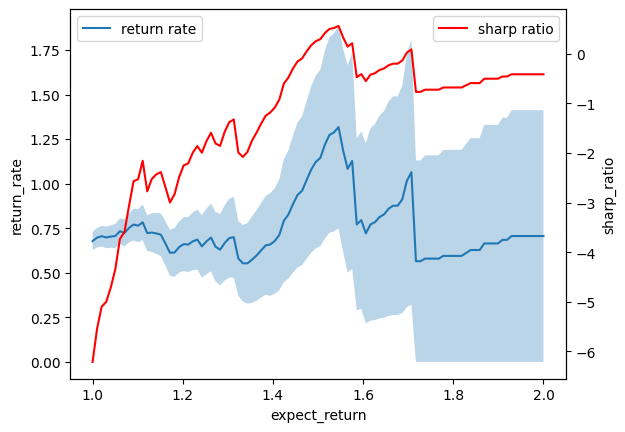

In [ ]:
result_df = evaluator.bet_by_expect_return(
    min_exp=1.0, max_exp=2.0,n_samples=100, min_pred=0.03, pred_col="pred_calibrated"
)

In [ ]:
result_df.sort_values("sharp_ratio", ascending=False).head()

,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
54,1.545455,86,113.3,1.317442,0.567471,6,0.559397
53,1.535354,88,113.3,1.287500,0.554932,6,0.518082
52,1.525253,89,113.3,1.273034,0.548867,6,0.497450
51,1.515152,93,113.3,1.218280,0.525875,6,0.415079
55,1.555556,81,96.2,1.187654,0.569159,5,0.329705


# 単勝ベット検証

In [ ]:
df = evaluator.evaluation_df
df

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred,pred_calibrated,expect_return,payoff,expect_return_calibrated
0,202401010101,2022105244,1,1,1.2,1,5,0.554308,0.482759,0.665170,1.2,0.579310
1,202401010101,2022106999,0,2,10.2,4,2,0.087241,0.100000,0.889861,0.0,1.020000
2,202401010101,2022100639,0,3,7.9,3,3,0.101807,0.111965,0.804278,0.0,0.884523
3,202401010101,2022105762,0,4,5.9,2,1,0.136837,0.111965,0.807337,0.0,0.660593
4,202401010101,2022100660,0,5,21.3,5,4,0.047171,0.051546,1.004740,0.0,1.097938
...,...,...,...,...,...,...,...,...,...,...,...,...
46122,202410030812,2020104913,0,11,32.3,9,7,0.023307,0.021870,0.752832,0.0,0.706410
46123,202410030812,2021110123,0,12,51.0,11,10,0.011989,0.006410,0.611427,0.0,0.326923
46124,202410030812,2020100160,0,13,167.0,15,8,0.003845,0.000000,0.642054,0.0,0.000000
46125,202410030812,2021101090,0,14,85.7,14,15,0.008608,0.004481,0.737746,0.0,0.384018


In [194]:
df["expect_return"] = df["tansho_odds"] * df["pred"]
df["expect_return_calibrated"] = df["tansho_odds"] * df["pred_calibrated"]
df

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred,pred_calibrated,expect_return,expect_return_calibrated
284777,202401010102,2021100728,0,5,90.0,10,10,0.009930,0.008584,0.893713,0.772532
284781,202401010102,2021103998,0,9,167.0,11,9,0.003618,0.002401,0.604208,0.400892
284783,202401010102,2021102364,0,11,172.5,12,1,0.003267,0.002401,0.563513,0.414095
284790,202401010103,2021100179,0,6,214.5,12,9,0.002430,0.002401,0.521324,0.514918
284791,202401010103,2021102630,0,7,106.0,10,14,0.008101,0.008163,0.858757,0.865306
...,...,...,...,...,...,...,...,...,...,...,...
330876,202410030811,2018100026,0,11,88.8,14,4,0.007964,0.008163,0.707168,0.724898
330879,202410030811,2018106834,0,14,68.1,13,1,0.009166,0.008163,0.624221,0.555918
330888,202410030812,2019101620,0,9,80.9,13,3,0.006877,0.004011,0.556373,0.324527
330892,202410030812,2020100160,0,13,167.0,15,8,0.004848,0.004011,0.809657,0.669914


In [195]:
# この中からpredが0.001以上0.01以下のものを抽出してみる
df = df[(df["pred"] >= 0.001) & (df["pred"] <= 0.01)]
df

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred,pred_calibrated,expect_return,expect_return_calibrated
284777,202401010102,2021100728,0,5,90.0,10,10,0.009930,0.008584,0.893713,0.772532
284781,202401010102,2021103998,0,9,167.0,11,9,0.003618,0.002401,0.604208,0.400892
284783,202401010102,2021102364,0,11,172.5,12,1,0.003267,0.002401,0.563513,0.414095
284790,202401010103,2021100179,0,6,214.5,12,9,0.002430,0.002401,0.521324,0.514918
284791,202401010103,2021102630,0,7,106.0,10,14,0.008101,0.008163,0.858757,0.865306
...,...,...,...,...,...,...,...,...,...,...,...
330876,202410030811,2018100026,0,11,88.8,14,4,0.007964,0.008163,0.707168,0.724898
330879,202410030811,2018106834,0,14,68.1,13,1,0.009166,0.008163,0.624221,0.555918
330888,202410030812,2019101620,0,9,80.9,13,3,0.006877,0.004011,0.556373,0.324527
330892,202410030812,2020100160,0,13,167.0,15,8,0.004848,0.004011,0.809657,0.669914


In [130]:
df["payoff"] = df["tansho_odds"] * df["target"]
sort_df = (
df.sort_values("expect_return_calibrated", ascending=False)
  .groupby("race_id")
  .head(1)
  # .groupby("race_id")["umaban"]
)
# これにexpect_return_calibratedが１を超えるもののみを抽出する
sort_df = sort_df[sort_df["expect_return_calibrated"] > 1]
sort_df

,race_id,horse_id,target,rank,tansho_odds,popularity,umaban,pred,pred_calibrated,expect_return,payoff,expect_return_calibrated
21966,202406030311,2020101533,0,13,127.5,16,16,0.073596,0.075314,9.383428,0.0,9.602510
30891,202408010311,2021103080,0,8,227.6,18,8,0.044153,0.037879,10.049326,0.0,8.621212
30316,202407040607,2021106982,0,13,197.2,14,2,0.045656,0.037879,9.003338,0.0,7.469697
42063,202409020711,2021102315,0,13,74.6,11,12,0.091623,0.100000,6.835063,0.0,7.460000
20774,202406020412,2019100055,0,9,100.5,13,4,0.053806,0.051546,5.407464,0.0,5.180412
...,...,...,...,...,...,...,...,...,...,...,...,...
19670,202406010508,2019102648,0,9,45.8,6,10,0.019618,0.021870,0.898484,0.0,1.001659
30520,202408010110,2018105074,0,5,45.8,9,7,0.014858,0.021870,0.680480,0.0,1.001659
36278,202408050208,2021101523,1,1,5.7,3,11,0.169108,0.175556,0.963916,5.7,1.000667
29639,202407040210,2021105775,0,5,5.7,2,3,0.155953,0.175556,0.888931,0.0,1.000667


In [ ]:
# 補正前
investment = sort_df["race_id"].nunique()
total_payoff = sort_df["payoff"].sum()
profit = total_payoff /investment
n_hits = sort_df["target"].sum()
investment, total_payoff, profit, n_hits

(3403, np.float64(2013.0), np.float64(0.5915368792242139), np.int64(156))

In [131]:
# 補正後
investment = sort_df["race_id"].nunique()
total_payoff = sort_df["payoff"].sum()
profit = total_payoff /investment
n_hits = sort_df["target"].sum()
investment, total_payoff, profit, n_hits

(2603, np.float64(1941.9), np.float64(0.7460238186707645), np.int64(121))